# Library Needed

In [1]:
!pip install fpgrowth_py

In [2]:
# BASE
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time

# ----------------------------
# INSTALL
# !pip install mlxtend

# ----------------------------
# TRANSACTION ENCODER
from mlxtend.preprocessing import TransactionEncoder

# ----------------------------
# FP-GROWTH Function
from fpgrowth_py import fpgrowth
from mlxtend.frequent_patterns import fpgrowth, association_rules

# ----------------------------
# ITERTOOLS
import itertools

# ----------------------------
# CONFIGURATION
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

In [3]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    print(f"Total data adalah: {data.shape[0]} Baris")
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [4]:
def check_duplicates(dataframe):
    """
    Memeriksa nilai duplikat dari DataFrame.
    """
    # Menampilkan nilai duplikat
    print("Nilai Duplikat (10 Teratas):")
    duplicate_values = dataframe[dataframe.duplicated()]
    print(f"Jumlah Duplikat data: {duplicate_values.shape[0]}")
    display(duplicate_values.head(10))

# Import Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Project [Data Bridge]/Analisis Pola Asosiasi Gangguan Jaringan IT Menggunakan Algoritma Apriori dan FP-Growth/Data/Dataset Association Rule Mining Gangguan.xlsx')

# Explore & Preprocessing Data

In [7]:
missing_data(df) # No Missing Data detect here, but actually there is some data with "-" and it's maybe a missing data...

Total data adalah: 7141 Baris


,Total,Percent
Ticket ID,0,0.00
Incident ID,0,0.00
BULAN,0,0.00
Created On,0,0.00
Service ID,0,0.00
Product,0,0.00
Interference (Incident ID) (Incident),0,0.00


In [8]:
check_duplicates(df)# No Duplicated Data, So Just Go on

Nilai Duplikat (10 Teratas):
Jumlah Duplikat data: 0


,Ticket ID,Incident ID,BULAN,Created On,Service ID,Product,Interference (Incident ID) (Incident)


In [9]:
# Rename Columns to something simpler
df.rename(columns={"BULAN": "Month", "Interference (Incident ID) (Incident)": "Interference(Incident)"}, inplace=True)

In [10]:
# Checks the value "-", whichever column contains it

for _, i in enumerate(df.columns):
  if df[df[i] == '-'].shape[0] == 0:
    continue
  else:
    print(f"\n {_}. {i}")
    display(df[df[i] == "-"].head(10))
    print(f"Jumlah value '-' adalah {df[df[i] == '-'].shape[0]}")


 1. Incident ID


,Ticket ID,Incident ID,Month,Created On,Service ID,Product,Interference(Incident)
3917,REBNMJMN,-,6,2023-06-26 11:21:00,1000094154,IPVPN,-
4038,REBNKCP3,-,6,2023-06-22 11:37:00,990000020264878,IPVPN,-
4132,REBBE8SC,-,6,2023-06-05 00:11:00,990000320269478,IPVPN,-
4234,RR9LJ7WX,-,6,2023-07-02 12:55:00,1000296826,IPVPN,-
4244,RR9LJ75R,-,6,2023-07-02 13:02:00,1000118377,IPVPN,-
4389,RR9LJKK2,-,6,2023-07-02 12:49:00,1000327407,IPVPN,-
4398,RR9LCDPB,-,6,2023-05-31 16:40:00,990000320433811,IPVPN,-
4408,RR9LC5Y8,-,6,2023-05-31 12:40:00,10000007240197,IPVPN,-
4708,RR9XYBG2,-,7,2023-07-31 15:23:00,990000320272385,IPVPN,-
4919,RYZ39CVL,-,8,2023-09-01 08:14:00,1000137053,METRO ETHERNET QINQ,-


Jumlah value '-' adalah 65

 6. Interference(Incident)


,Ticket ID,Incident ID,Month,Created On,Service ID,Product,Interference(Incident)
3917,REBNMJMN,-,6,2023-06-26 11:21:00,1000094154,IPVPN,-
4038,REBNKCP3,-,6,2023-06-22 11:37:00,990000020264878,IPVPN,-
4119,REBBVJ58,23062305668,6,2023-06-14 17:49:00,990000020276831,IPVPN,-
4132,REBBE8SC,-,6,2023-06-05 00:11:00,990000320269478,IPVPN,-
4234,RR9LJ7WX,-,6,2023-07-02 12:55:00,1000296826,IPVPN,-
4244,RR9LJ75R,-,6,2023-07-02 13:02:00,1000118377,IPVPN,-
4389,RR9LJKK2,-,6,2023-07-02 12:49:00,1000327407,IPVPN,-
4398,RR9LCDPB,-,6,2023-05-31 16:40:00,990000320433811,IPVPN,-
4408,RR9LC5Y8,-,6,2023-05-31 12:40:00,10000007240197,IPVPN,-
4708,RR9XYBG2,-,7,2023-07-31 15:23:00,990000320272385,IPVPN,-


Jumlah value '-' adalah 503


In [11]:
# Replace the "-" value with the integer 0 in the 'Incident ID' column
df['Incident ID'] = df['Incident ID'].replace("-", 0).astype(int)
# Replace the "-" value with the NaN Value in the 'Interference(Incident)' column
df['Interference(Incident)'] = df['Interference(Incident)'].replace("-", np.nan)

In [12]:
display(missing_data(df)) # Missing value is only 7% of the total data, so we just drop it

Total data adalah: 7141 Baris


,Total,Percent
Interference(Incident),503,7.04
Ticket ID,0,0.00
Incident ID,0,0.00
Month,0,0.00
Created On,0,0.00
Service ID,0,0.00
Product,0,0.00


In [13]:
df = df.dropna(subset="Interference(Incident)")

In [14]:
# There are some values that are likely due to human error in data input, so we get a "#" at the end
df['Service ID'] = df['Service ID'].replace('0990000320479567#', "0990000320479567")
df['Service ID'] = df['Service ID'].replace('0990000320520808#', "0990000320479567")

In [15]:
# Mengonversi kolom 'Incident ID' dan 'Ticket ID' ke dalam tipe data integer
df['Incident ID'] = df['Incident ID'].astype(int)

In [16]:
df['Service ID'] = df['Service ID'].astype(int)

In [17]:
df.reset_index(drop=True, inplace = True)

In [18]:
for n, c in enumerate(df.columns):
  is_unique = df[c].is_unique
  if is_unique == True:
    print(f"{n}. [{c}] column is Unique")
  else:
    print(f"{n}. [{c}] column isn't Unique")

0. [Ticket ID] column is Unique
1. [Incident ID] column isn't Unique
2. [Month] column isn't Unique
3. [Created On] column isn't Unique
4. [Service ID] column isn't Unique
5. [Product] column isn't Unique
6. [Interference(Incident)] column isn't Unique


# Data Visualization

In [19]:
def annotate_bars(ax, values, offset_x=0, offset_y=0):
    for i, value in enumerate(values):
        ax.annotate(f'{value}', xy=(i, value), xytext=(offset_x, offset_y), textcoords="offset points",
                    ha='center', va='bottom')

In [20]:
def annotate_bars_h(ax, values, offset_x=0, offset_y=0):
    for i, value in enumerate(values):
        ax.annotate(f'{value}', xy=(value, i), xytext=(offset_x, offset_y), textcoords="offset points",
                    ha='left', va='center')

## frequency of appearance for each product

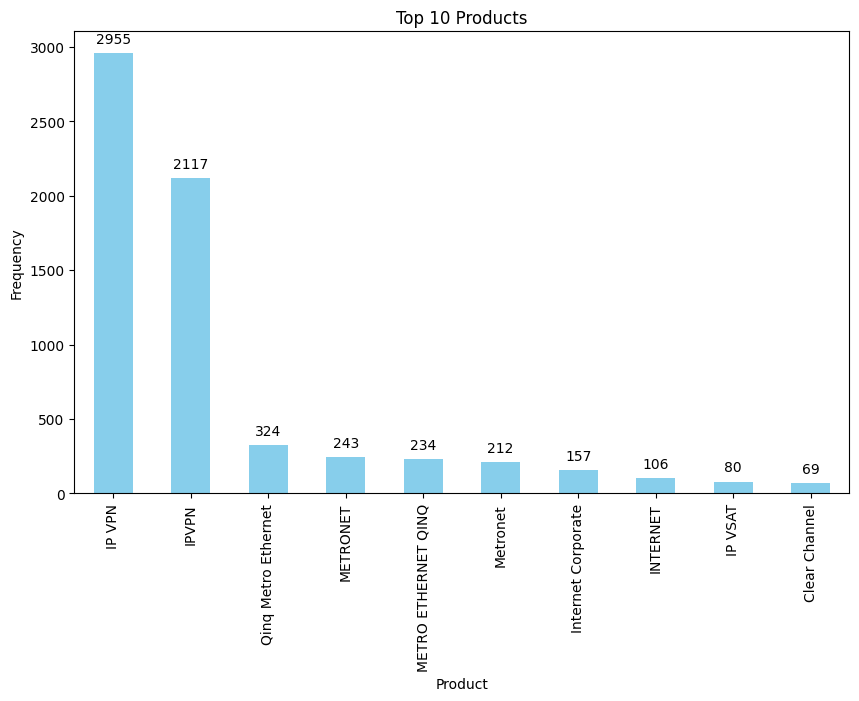

In [21]:
top_products = df['Product'].value_counts().head(10)

# Visualisasi top 10 produk
plt.figure(figsize=(10, 6))
top_products.plot(kind='bar', color='skyblue')
plt.title('Top 10 Products')
plt.xlabel('Product')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
annotate_bars(plt.gca(), top_products, offset_y=5)
plt.show()

## Frequency of occurrence for each Service ID

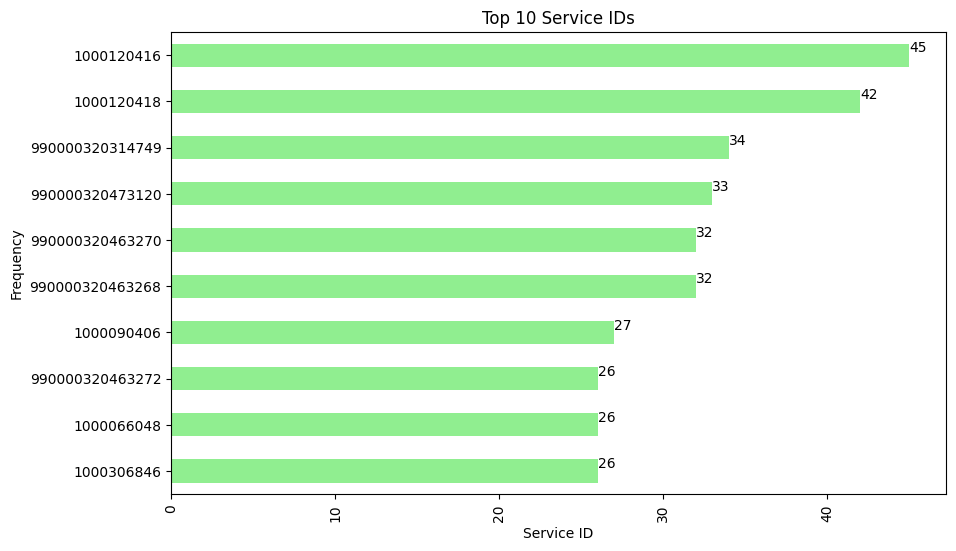

In [22]:
top_service_ids = df['Service ID'].value_counts().head(10).sort_values(ascending=True)

# Visualisasi top 10 Service ID
plt.figure(figsize=(10, 6))
top_service_ids.plot(kind='barh', color='lightgreen')
plt.title('Top 10 Service IDs')
plt.xlabel('Service ID')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
annotate_bars_h(plt.gca(), top_service_ids, offset_y=5)
plt.show()

## Frequency of occurrence for each Interference(Incident)

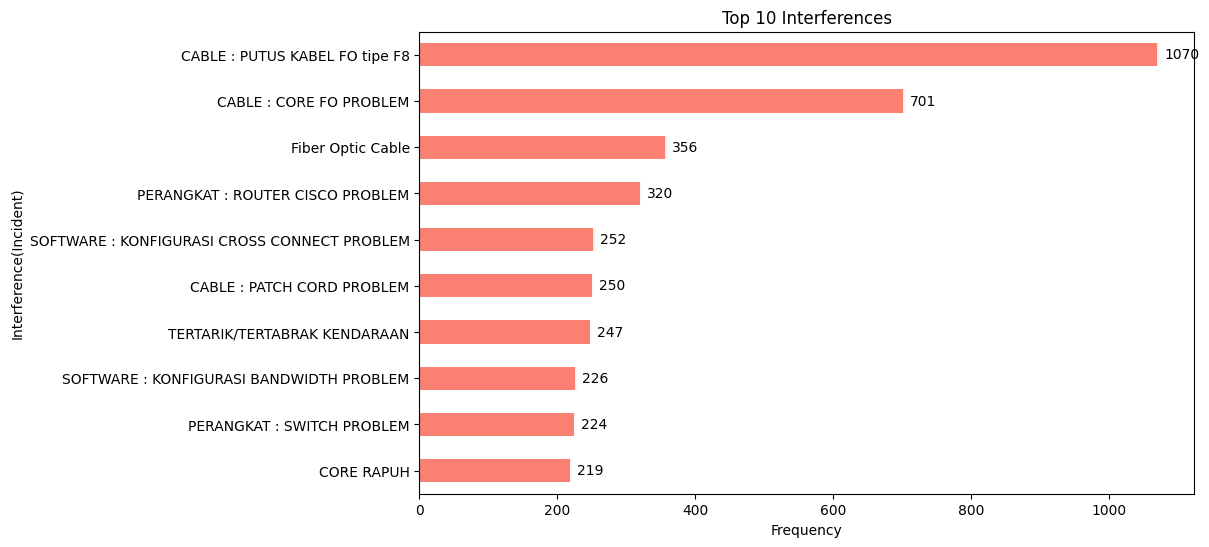

In [23]:
# Calculate top 10 Interferences
top_interferences = df['Interference(Incident)'].value_counts().head(10).sort_values(ascending=True)

# Visualize top 10 Interferences
plt.figure(figsize=(10, 6))
top_interferences.plot(kind='barh', color='salmon')
plt.title('Top 10 Interferences')
plt.xlabel('Frequency')
plt.ylabel('Interference(Incident)')
plt.xticks(rotation=0)

# Annotate bars
annotate_bars_h(plt.gca(), top_interferences, offset_x=5)

plt.show()

## Total number of entries for each month

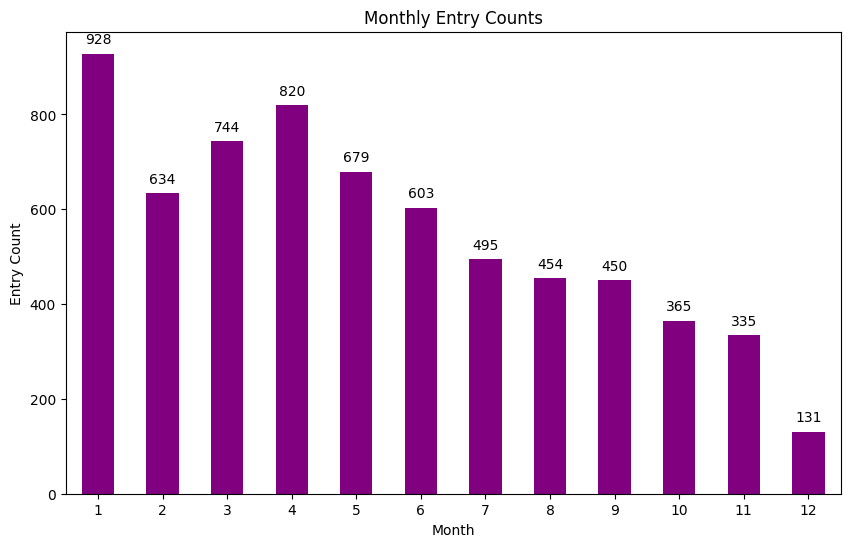

In [24]:
monthly_counts = df.groupby('Month').size()

# Visualisasi jumlah keseluruhan entri untuk setiap bulan
plt.figure(figsize=(10, 6))
monthly_counts.plot(kind='bar', color='purple')
plt.title('Monthly Entry Counts')
plt.xlabel('Month')
plt.ylabel('Entry Count')
plt.xticks(rotation=0)
annotate_bars(plt.gca(), monthly_counts, offset_y=5)
plt.show()

# FP-GROWTH Requirements

1. Ubah dataset ke dalam format yang sesuai untuk analisis asosiasi. Pastikan setiap baris mewakili satu transaksi atau kejadian, dan atribut atau variabel yang akan dianalisis adalah Interference(Incident).

2. Transformasi dataset menjadi format transaksi atau itemset. Ini berarti setiap transaksi atau kejadian harus berisi kumpulan item yang terjadi bersamaan atau berurutan. Dalam kasus ini, Anda akan ingin melihat apakah ada pola asosiasi antara jenis-jenis gangguan yang terjadi.

Contoh:

|   Transaction ID | Items                  |
|------------------|------------------------|
|               1  | {'item1', 'item2', 'item5'} |
|               2  | {'item2', 'item4'}         |
|               3  | {'item1', 'item2', 'item4'} |
|               4  | {'item1', 'item3'}         |
|               5  | {'item2', 'item3'}         |

## First Way

In [25]:
# Group by 'Service ID' and aggregate 'Interference(Incident)' as sets
interference_itemsets = df.groupby('Service ID')['Interference(Incident)'].apply(set).reset_index()
# Rename columns
interference_itemsets.columns = ['Service ID', 'Interference(Incident) Set']

# Print DataFrame
interference_itemsets

,Service ID,Interference(Incident) Set
0,1000001749,"{POWER : AC SUPPLY POWER LOST DI POP, SOFTWARE..."
1,1000001771,"{CORE RAPUH, POWER : AC SUPPLY POWER LOST DI P..."
2,1000001820,"{CABLE : PATCH CORD PROBLEM, SOFTWARE : KONFIG..."
3,1000003671,{VANDALISME}
4,1000003673,"{PUTUS PROTECT, PERANGKAT : MODUL PROBLEM}"
...,...,...
1910,990000320656159,{PERANGKAT : ROUTER CISCO PROBLEM}
1911,990000320657940,"{DROPWIRE CUT, CABLE : CORE FO PROBLEM, POWER ..."
1912,990000320682576,{HARDWARE}
1913,990000320682672,"{CABLE : PUTUS KABEL FO tipe F8, JB_RUSAK}"


In [26]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

In [27]:
# Convert the set of incidents into a list of lists
transactions = list(interference_itemsets['Interference(Incident) Set'])

In [28]:
# Initialize and fit the transaction encoder
encoder = TransactionEncoder()
encoder_array = encoder.fit_transform(transactions)

In [29]:
# Convert the encoded array into a DataFrame
df_encoded = pd.DataFrame(encoder_array, columns=encoder.columns_)

In [30]:
df_encoded

,AC SUPPLY POWER LOST DI LASTMILE,AC SUPPLY POWER LOST DI POP,ADAPTOR CONVERTER PROBLEM,ADAPTOR ROUTER,ANTENA VSAT PROBLEM,ATS/COS PROBLEM,BAD PERFOMANCE PIHAK KETIGA,BAD SPLICING,BATTERY / RECTIFIER PROBLEM,BATTERY PROBLEM,BENCANA ALAM,BW REDUCE,CABLE : CORE BENDING,CABLE : CORE FO PROBLEM,CABLE : FO BENDING,CABLE : PATCH CORD PROBLEM,CABLE : PUTUS KABEL FO tipe F8,CABLE POWER PROBLEM,CARD MODUL PROBLEM,CDWM_PUTUS CORE,CONFIGURATION ERROR,CONNECTOR BAD,CONNECTOR BULKHEAD PROBLEM,CONVERTER PROBLEM,CONVERTER/SFP PROBLEM,CORE BENDING,CORE FO PROBLEM,CORE FO TEGANG / TERTEKUK,CORE RAPUH,CWDM - BEBERAPA PORT / LAMDA TIDAK BERFUNGSI BAIK,CWDM - REDAMAN BESAR,CWDM - UNIT RUSAK,DIGIGIT BINATANG,DISTRIBUSI CUT,DNS PROBLEM,DROPWIRE BENDING,DROPWIRE CUT,DRYBAND/INDUKSI,DWDM PROBLEM,EXTERNAL ALARM PROBLEM,FDT BROKEN,FEEDER BENDING,FEEDER CUT,FO CUT,FULL TRAFFIC,Fiber Optic Cable,Fiber Optic Terminal,GANGGUAN SISI PERANGKAT USER,GPON BROKEN /HANG DUE TO OVER HEAT,GPON BROKEN DUE TO LIFETIME/PERFORMANCE,HARDWARE,IMPACT PEKERJAAN PROYEK,INVERTER PROBLEM,JB_AKTIVITAS TRACING,JB_CORE DIPAKAI PROJECT/AKTIVASI,JB_RUSAK,KONFIGURASI BANDWIDTH PROBLEM,KONFIGURASI CONVERTER PROBLEM,KONFIGURASI CROSS CONNECT PROBLEM,KONFIGURASI DI ROUTER PROBLEM,KONFIGURASI DI SWITCH PROBLEM,KONFIGURASI DI TELICON PROBLEM,LAINNYA,LAINNYA : LAINNYA,LISTRIK LASTMILE MATI,LNB VSAT,LOKAL PIHAK KETIGA,LOSS POWER,MAIL PROBLEM,MAINTENANCE,MCB PROBLEM,MIKROTIK PROBLEM,MISCONFIGURATION,MODEM PROBLEM,MODEM VSAT PROBLEM,MODUL PROBLEM,ODF_PIGTAIL RUSAK,ODF_PUTUS CORE,ONT HANG/BROKEN,OTHER,PATCHCORD BENDING,PATCHCORD PUTUS,PDH LASTMILE PROBLEM,PEMINDAHAN PERANGKAT,PENDINGIN PERANGKAT RUSAK,PENGECEKAN OK,PERANGKAT : ADAPTOR CONVERTER PROBLEM,PERANGKAT : ADAPTOR ROUTER,PERANGKAT : CARD MODUL PROBLEM,PERANGKAT : CONVERTER PROBLEM,PERANGKAT : MODEM VSAT PROBLEM,PERANGKAT : MODUL PROBLEM,PERANGKAT : PORT CONVERTER PROBLEM,PERANGKAT : PORT MODUL PROBLEM,PERANGKAT : PORT SWITCH PROBLEM,PERANGKAT : ROUTER CISCO PROBLEM,PERANGKAT : ROUTER PROBLEM,PERANGKAT : SWITCH PROBLEM,PERANGKAT : VSAT PROBLEM,PERANGKAT LNB VSAT,PERAPIHAN LASTMILE,PIGTAIL,PORT BROKEN,PORT CONVERTER PROBLEM,PORT SWITCH PROBLEM,POWER : AC SUPPLY POWER LOST DI LASTMILE,POWER : AC SUPPLY POWER LOST DI POP,POWER : ATTENUATOR PROBLEM,POWER : BATTERY / RECTIFIER PROBLEM,POWER : CABLE POWER PROBLEM,POWER : MCB PROBLEM,POWER : SOURCE POWER PROBLEM,PUTUS KABEL FO TIPE ADSS,PUTUS KABEL FO TIPE F8,PUTUS PROTECT,Power Supply,RABAS - RABAS,REBOOT,RECONFIG CPE/ROUTER/VSAT LASTMILE,RECTIFIER PROBLEM,ROUTER CISCO PROBLEM,ROUTER POP PROBLEM,ROUTER PROBLEM,SALAH OPEN SID,SDH PROBLEM,SERVER : DNS PROBLEM,SIGNAL HIGH,SIGNAL LOSS,SINYAL VSAT PROBLEM,SOFTWARE,SOFTWARE : KONFIGURASI BANDWIDTH PROBLEM,SOFTWARE : KONFIGURASI CONVERTER PROBLEM,SOFTWARE : KONFIGURASI CROSS CONNECT PROBLEM,SOFTWARE : KONFIGURASI DI ROUTER PROBLEM,SOFTWARE : KONFIGURASI DI SWITCH PROBLEM,SOFTWARE PARAMETER SETTING CONFIGURATION,SOFTWARE ROUTING PROBLEM,SOURCE POWER PROBLEM,SPLITTER BROKEN,SUDAH DEACTIVASI,SWITCH LASTMILE PROBLEM,SWITCH PROBLEM,TELICON PROBLEM,TERBAKAR,TERJEPIT DI FAT,TERJEPIT DI FDT,TERJEPIT DI JB,TERJEPIT DI ODF,TERSAYAT/KEBACOK/KECANGKUL,TERTARIK/TERTABRAK KENDARAAN,UP AUTOMATICALLY,UPPERLEVEL PROBLEM,UPS PROBLEM,UTP / STP PROBLEM,UTP LEPAS DI LASTMILE,UTP RUSAK,VANDALISME,VSAT PUSAT (GANDUL) PROBLEM,WIRING PANEL ACDB/DCDB PROBLEM,WIRING VSAT RUSAK,WIRRING : CONNECTOR BULKHEAD PROBLEM,WIRRING : UTP / STP PROBLEM
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

## Another Way

In [31]:
# Transactions done in France
interference_itemsets_sum = (df.groupby(['Service ID', 'Interference(Incident)'])['Interference(Incident)']
		.count().unstack().reset_index().fillna(0)
		.set_index('Service ID'))

In [32]:
# Defining the hot encoding function to make the data suitable
# for the concerned libraries
def hot_encode(x):
    if(x<= 0):
        return 0
    if(x>= 1):
        return 1

# Encoding the datasets
interference_itemsets_sum_encoded = interference_itemsets_sum.applymap(hot_encode)

In [33]:
interference_itemsets_sum_encoded

Interference(Incident),AC SUPPLY POWER LOST DI LASTMILE,AC SUPPLY POWER LOST DI POP,ADAPTOR CONVERTER PROBLEM,ADAPTOR ROUTER,ANTENA VSAT PROBLEM,ATS/COS PROBLEM,BAD PERFOMANCE PIHAK KETIGA,BAD SPLICING,BATTERY / RECTIFIER PROBLEM,BATTERY PROBLEM,BENCANA ALAM,BW REDUCE,CABLE : CORE BENDING,CABLE : CORE FO PROBLEM,CABLE : FO BENDING,CABLE : PATCH CORD PROBLEM,CABLE : PUTUS KABEL FO tipe F8,CABLE POWER PROBLEM,CARD MODUL PROBLEM,CDWM_PUTUS CORE,CONFIGURATION ERROR,CONNECTOR BAD,CONNECTOR BULKHEAD PROBLEM,CONVERTER PROBLEM,CONVERTER/SFP PROBLEM,CORE BENDING,CORE FO PROBLEM,CORE FO TEGANG / TERTEKUK,CORE RAPUH,CWDM - BEBERAPA PORT / LAMDA TIDAK BERFUNGSI BAIK,CWDM - REDAMAN BESAR,CWDM - UNIT RUSAK,DIGIGIT BINATANG,DISTRIBUSI CUT,DNS PROBLEM,DROPWIRE BENDING,DROPWIRE CUT,DRYBAND/INDUKSI,DWDM PROBLEM,EXTERNAL ALARM PROBLEM,FDT BROKEN,FEEDER BENDING,FEEDER CUT,FO CUT,FULL TRAFFIC,Fiber Optic Cable,Fiber Optic Terminal,GANGGUAN SISI PERANGKAT USER,GPON BROKEN /HANG DUE TO OVER HEAT,GPON BROKEN DUE TO LIFETIME/PERFORMANCE,HARDWARE,IMPACT PEKERJAAN PROYEK,INVERTER PROBLEM,JB_AKTIVITAS TRACING,JB_CORE DIPAKAI PROJECT/AKTIVASI,JB_RUSAK,KONFIGURASI BANDWIDTH PROBLEM,KONFIGURASI CONVERTER PROBLEM,KONFIGURASI CROSS CONNECT PROBLEM,KONFIGURASI DI ROUTER PROBLEM,KONFIGURASI DI SWITCH PROBLEM,KONFIGURASI DI TELICON PROBLEM,LAINNYA,LAINNYA : LAINNYA,LISTRIK LASTMILE MATI,LNB VSAT,LOKAL PIHAK KETIGA,LOSS POWER,MAIL PROBLEM,MAINTENANCE,MCB PROBLEM,MIKROTIK PROBLEM,MISCONFIGURATION,MODEM PROBLEM,MODEM VSAT PROBLEM,MODUL PROBLEM,ODF_PIGTAIL RUSAK,ODF_PUTUS CORE,ONT HANG/BROKEN,OTHER,PATCHCORD BENDING,PATCHCORD PUTUS,PDH LASTMILE PROBLEM,PEMINDAHAN PERANGKAT,PENDINGIN PERANGKAT RUSAK,PENGECEKAN OK,PERANGKAT : ADAPTOR CONVERTER PROBLEM,PERANGKAT : ADAPTOR ROUTER,PERANGKAT : CARD MODUL PROBLEM,PERANGKAT : CONVERTER PROBLEM,PERANGKAT : MODEM VSAT PROBLEM,PERANGKAT : MODUL PROBLEM,PERANGKAT : PORT CONVERTER PROBLEM,PERANGKAT : PORT MODUL PROBLEM,PERANGKAT : PORT SWITCH PROBLEM,PERANGKAT : ROUTER CISCO PROBLEM,PERANGKAT : ROUTER PROBLEM,PERANGKAT : SWITCH PROBLEM,PERANGKAT : VSAT PROBLEM,PERANGKAT LNB VSAT,PERAPIHAN LASTMILE,PIGTAIL,PORT BROKEN,PORT CONVERTER PROBLEM,PORT SWITCH PROBLEM,POWER : AC SUPPLY POWER LOST DI LASTMILE,POWER : AC SUPPLY POWER LOST DI POP,POWER : ATTENUATOR PROBLEM,POWER : BATTERY / RECTIFIER PROBLEM,POWER : CABLE POWER PROBLEM,POWER : MCB PROBLEM,POWER : SOURCE POWER PROBLEM,PUTUS KABEL FO TIPE ADSS,PUTUS KABEL FO TIPE F8,PUTUS PROTECT,Power Supply,RABAS - RABAS,REBOOT,RECONFIG CPE/ROUTER/VSAT LASTMILE,RECTIFIER PROBLEM,ROUTER CISCO PROBLEM,ROUTER POP PROBLEM,ROUTER PROBLEM,SALAH OPEN SID,SDH PROBLEM,SERVER : DNS PROBLEM,SIGNAL HIGH,SIGNAL LOSS,SINYAL VSAT PROBLEM,SOFTWARE,SOFTWARE : KONFIGURASI BANDWIDTH PROBLEM,SOFTWARE : KONFIGURASI CONVERTER PROBLEM,SOFTWARE : KONFIGURASI CROSS CONNECT PROBLEM,SOFTWARE : KONFIGURASI DI ROUTER PROBLEM,SOFTWARE : KONFIGURASI DI SWITCH PROBLEM,SOFTWARE PARAMETER SETTING CONFIGURATION,SOFTWARE ROUTING PROBLEM,SOURCE POWER PROBLEM,SPLITTER BROKEN,SUDAH DEACTIVASI,SWITCH LASTMILE PROBLEM,SWITCH PROBLEM,TELICON PROBLEM,TERBAKAR,TERJEPIT DI FAT,TERJEPIT DI FDT,TERJEPIT DI JB,TERJEPIT DI ODF,TERSAYAT/KEBACOK/KECANGKUL,TERTARIK/TERTABRAK KENDARAAN,UP AUTOMATICALLY,UPPERLEVEL PROBLEM,UPS PROBLEM,UTP / STP PROBLEM,UTP LEPAS DI LASTMILE,UTP RUSAK,VANDALISME,VSAT PUSAT (GANDUL) PROBLEM,WIRING PANEL ACDB/DCDB PROBLEM,WIRING VSAT RUSAK,WIRRING : CONNECTOR BULKHEAD PROBLEM,WIRRING : UTP / STP PROBLEM
Service ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000001749,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1000001771,0

In [34]:
interference_itemsets_sum_encoded.sum()

Interference(Incident)
AC SUPPLY POWER LOST DI LASTMILE        11
AC SUPPLY POWER LOST DI POP             35
ADAPTOR CONVERTER PROBLEM                4
ADAPTOR ROUTER                          12
ANTENA VSAT PROBLEM                      2
                                        ..
VSAT PUSAT (GANDUL) PROBLEM              3
WIRING PANEL ACDB/DCDB PROBLEM           1
WIRING VSAT RUSAK                        5
WIRRING : CONNECTOR BULKHEAD PROBLEM     4
WIRRING : UTP / STP PROBLEM             35
Length: 162, dtype: int64

In [35]:
df_encoded.sum()

AC SUPPLY POWER LOST DI LASTMILE        11
AC SUPPLY POWER LOST DI POP             35
ADAPTOR CONVERTER PROBLEM                4
ADAPTOR ROUTER                          12
ANTENA VSAT PROBLEM                      2
                                        ..
VSAT PUSAT (GANDUL) PROBLEM              3
WIRING PANEL ACDB/DCDB PROBLEM           1
WIRING VSAT RUSAK                        5
WIRRING : CONNECTOR BULKHEAD PROBLEM     4
WIRRING : UTP / STP PROBLEM             35
Length: 162, dtype: int64

In [36]:
## Now it's up to you which dataset you want to use

# FP_GROWTH Applied to Dataset

In [37]:
df_encoded

,AC SUPPLY POWER LOST DI LASTMILE,AC SUPPLY POWER LOST DI POP,ADAPTOR CONVERTER PROBLEM,ADAPTOR ROUTER,ANTENA VSAT PROBLEM,ATS/COS PROBLEM,BAD PERFOMANCE PIHAK KETIGA,BAD SPLICING,BATTERY / RECTIFIER PROBLEM,BATTERY PROBLEM,BENCANA ALAM,BW REDUCE,CABLE : CORE BENDING,CABLE : CORE FO PROBLEM,CABLE : FO BENDING,CABLE : PATCH CORD PROBLEM,CABLE : PUTUS KABEL FO tipe F8,CABLE POWER PROBLEM,CARD MODUL PROBLEM,CDWM_PUTUS CORE,CONFIGURATION ERROR,CONNECTOR BAD,CONNECTOR BULKHEAD PROBLEM,CONVERTER PROBLEM,CONVERTER/SFP PROBLEM,CORE BENDING,CORE FO PROBLEM,CORE FO TEGANG / TERTEKUK,CORE RAPUH,CWDM - BEBERAPA PORT / LAMDA TIDAK BERFUNGSI BAIK,CWDM - REDAMAN BESAR,CWDM - UNIT RUSAK,DIGIGIT BINATANG,DISTRIBUSI CUT,DNS PROBLEM,DROPWIRE BENDING,DROPWIRE CUT,DRYBAND/INDUKSI,DWDM PROBLEM,EXTERNAL ALARM PROBLEM,FDT BROKEN,FEEDER BENDING,FEEDER CUT,FO CUT,FULL TRAFFIC,Fiber Optic Cable,Fiber Optic Terminal,GANGGUAN SISI PERANGKAT USER,GPON BROKEN /HANG DUE TO OVER HEAT,GPON BROKEN DUE TO LIFETIME/PERFORMANCE,HARDWARE,IMPACT PEKERJAAN PROYEK,INVERTER PROBLEM,JB_AKTIVITAS TRACING,JB_CORE DIPAKAI PROJECT/AKTIVASI,JB_RUSAK,KONFIGURASI BANDWIDTH PROBLEM,KONFIGURASI CONVERTER PROBLEM,KONFIGURASI CROSS CONNECT PROBLEM,KONFIGURASI DI ROUTER PROBLEM,KONFIGURASI DI SWITCH PROBLEM,KONFIGURASI DI TELICON PROBLEM,LAINNYA,LAINNYA : LAINNYA,LISTRIK LASTMILE MATI,LNB VSAT,LOKAL PIHAK KETIGA,LOSS POWER,MAIL PROBLEM,MAINTENANCE,MCB PROBLEM,MIKROTIK PROBLEM,MISCONFIGURATION,MODEM PROBLEM,MODEM VSAT PROBLEM,MODUL PROBLEM,ODF_PIGTAIL RUSAK,ODF_PUTUS CORE,ONT HANG/BROKEN,OTHER,PATCHCORD BENDING,PATCHCORD PUTUS,PDH LASTMILE PROBLEM,PEMINDAHAN PERANGKAT,PENDINGIN PERANGKAT RUSAK,PENGECEKAN OK,PERANGKAT : ADAPTOR CONVERTER PROBLEM,PERANGKAT : ADAPTOR ROUTER,PERANGKAT : CARD MODUL PROBLEM,PERANGKAT : CONVERTER PROBLEM,PERANGKAT : MODEM VSAT PROBLEM,PERANGKAT : MODUL PROBLEM,PERANGKAT : PORT CONVERTER PROBLEM,PERANGKAT : PORT MODUL PROBLEM,PERANGKAT : PORT SWITCH PROBLEM,PERANGKAT : ROUTER CISCO PROBLEM,PERANGKAT : ROUTER PROBLEM,PERANGKAT : SWITCH PROBLEM,PERANGKAT : VSAT PROBLEM,PERANGKAT LNB VSAT,PERAPIHAN LASTMILE,PIGTAIL,PORT BROKEN,PORT CONVERTER PROBLEM,PORT SWITCH PROBLEM,POWER : AC SUPPLY POWER LOST DI LASTMILE,POWER : AC SUPPLY POWER LOST DI POP,POWER : ATTENUATOR PROBLEM,POWER : BATTERY / RECTIFIER PROBLEM,POWER : CABLE POWER PROBLEM,POWER : MCB PROBLEM,POWER : SOURCE POWER PROBLEM,PUTUS KABEL FO TIPE ADSS,PUTUS KABEL FO TIPE F8,PUTUS PROTECT,Power Supply,RABAS - RABAS,REBOOT,RECONFIG CPE/ROUTER/VSAT LASTMILE,RECTIFIER PROBLEM,ROUTER CISCO PROBLEM,ROUTER POP PROBLEM,ROUTER PROBLEM,SALAH OPEN SID,SDH PROBLEM,SERVER : DNS PROBLEM,SIGNAL HIGH,SIGNAL LOSS,SINYAL VSAT PROBLEM,SOFTWARE,SOFTWARE : KONFIGURASI BANDWIDTH PROBLEM,SOFTWARE : KONFIGURASI CONVERTER PROBLEM,SOFTWARE : KONFIGURASI CROSS CONNECT PROBLEM,SOFTWARE : KONFIGURASI DI ROUTER PROBLEM,SOFTWARE : KONFIGURASI DI SWITCH PROBLEM,SOFTWARE PARAMETER SETTING CONFIGURATION,SOFTWARE ROUTING PROBLEM,SOURCE POWER PROBLEM,SPLITTER BROKEN,SUDAH DEACTIVASI,SWITCH LASTMILE PROBLEM,SWITCH PROBLEM,TELICON PROBLEM,TERBAKAR,TERJEPIT DI FAT,TERJEPIT DI FDT,TERJEPIT DI JB,TERJEPIT DI ODF,TERSAYAT/KEBACOK/KECANGKUL,TERTARIK/TERTABRAK KENDARAAN,UP AUTOMATICALLY,UPPERLEVEL PROBLEM,UPS PROBLEM,UTP / STP PROBLEM,UTP LEPAS DI LASTMILE,UTP RUSAK,VANDALISME,VSAT PUSAT (GANDUL) PROBLEM,WIRING PANEL ACDB/DCDB PROBLEM,WIRING VSAT RUSAK,WIRRING : CONNECTOR BULKHEAD PROBLEM,WIRRING : UTP / STP PROBLEM
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [38]:
def show_duration(start, end):
  duration = end - start
  print("\nDuration:", duration, "seconds")
  duration_minutes = duration / 60
  print("Duration:", duration_minutes, "minutes")
  duration_hours = duration / 3600
  print("Duration:", duration_hours, "hours")

In [39]:
start = time.time()
frequent_itemsets_fp = fpgrowth(df_encoded, min_support=0.01, use_colnames=True)
end = time.time()

show_duration(start, end)


Duration: 0.23132014274597168 seconds
Duration: 0.0038553357124328615 minutes
Duration: 6.425559520721435e-05 hours


In [40]:
frequent_itemsets_fp = frequent_itemsets_fp.sort_values(by="support", ascending = False).reset_index(drop = True)

In [41]:
frequent_itemsets_fp

,support,itemsets
0,0.35,(CABLE : PUTUS KABEL FO tipe F8)
1,0.23,(CABLE : CORE FO PROBLEM)
2,0.17,(PERANGKAT : ROUTER CISCO PROBLEM)
3,0.15,(Fiber Optic Cable)
4,0.12,"(CABLE : CORE FO PROBLEM, CABLE : PUTUS KABEL ..."
...,...,...
193,0.01,"(CORE RAPUH, TERTARIK/TERTABRAK KENDARAAN, Fib..."
194,0.01,"(CABLE : CORE FO PROBLEM, Fiber Optic Cable, S..."
195,0.01,"(CABLE : CORE FO PROBLEM, LAINNYA)"
196,0.01,"(PERANGKAT : ROUTER CISCO PROBLEM, PERANGKAT :..."


In [42]:
rules_fp = association_rules(frequent_itemsets_fp, metric="confidence", min_threshold=0.2)

In [43]:
rules_fp.sort_values(by=["confidence","lift"], ascending = False).reset_index(drop = True)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,"(BW REDUCE, CABLE : CORE FO PROBLEM, TERTARIK/...",(CABLE : PUTUS KABEL FO tipe F8),0.01,0.35,0.01,1.00,2.85,0.01,inf,0.66
1,"(MODUL PROBLEM, ATS/COS PROBLEM, SOFTWARE : KO...",(Fiber Optic Cable),0.01,0.15,0.01,1.00,6.51,0.01,inf,0.86
2,"(BW REDUCE, TERTARIK/TERTABRAK KENDARAAN)",(CABLE : PUTUS KABEL FO tipe F8),0.04,0.35,0.04,1.00,2.85,0.02,inf,0.67
3,"(PERANGKAT : ROUTER CISCO PROBLEM, ATS/COS PRO...",(SOFTWARE : KONFIGURASI BANDWIDTH PROBLEM),0.01,0.08,0.01,1.00,12.68,0.01,inf,0.93
4,"(PERANGKAT : ROUTER CISCO PROBLEM, ATS/COS PRO...",(Fiber Optic Cable),0.01,0.15,0.01,1.00,6.51,0.01,inf,0.86
...,...,...,...,...,...,...,...,...,...,...
397,(POWER : AC SUPPLY POWER LOST DI POP),(Fiber Optic Cable),0.07,0.15,0.02,0.21,1.34,0.00,1.07,0.27
398,(Fiber Optic Cable),(TERTARIK/TERTABRAK KENDARAAN),0.15,0.11,0.03,0.20,1.92,0.01,1.12,0.56
399,"(CABLE : CORE FO PROBLEM, CABLE : PUTUS KABEL ...",(CORE RAPUH),0.12,0.08,0.02,0.20,2.43,0.01,1.15,0.66
400,(TERTARIK/TERTABRAK KENDARAAN),"(CABLE : CORE FO PROBLEM, Fiber Optic Cable)",0.11,0.06,0.02,0.20,3.21,0.01,1.17,0.77


[Refrensi Belajar](https://www.youtube.com/watch?v=7oGz4PCp9jI)